## Research Project Name:
### Feature Engineering using Signal Processing to predict DTC and DTS values

In this project we aim to find out the effect of Wavelet Transformation a signal Processing technique on DTC and DTS velocities prediction

### Timeline for the project:
- DTC and DTS prediction using normal log data
- Wavelet Transforamtion is performed on the log data
- DTC and DtS prediction using transformed data

### 1) DTC and DTS prediction usign XG Boost Regression model

#### This will include the following steps:
- Imports
- Data exploration and Prepration
- Model Development
- Model Prediction and evaluation

Data is taken from Synthethic Sonic Log Curves Generation Contest 

#### Description fo the data:
- CAL - Caliper, unit in Inch,
- CNC - Neutron, unit in dec
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter,
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,

#### Importing libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

import xgboost as xgb

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv("test.csv")

In [3]:
print(train_df.shape,test_df.shape)

(30143, 9) (11088, 7)


In [4]:
train_df.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


In [5]:
test_df.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
count,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000
mean,8.634049,0.158501,28.966414,4.028372,106.752210,7.353522,2.475884
std,0.044064,0.091298,43.648163,7.198112,2374.620246,1.239075,0.149440
min,8.500000,0.009800,0.852000,0.083900,0.102700,4.760800,2.033400
25%,8.625000,0.091700,8.449450,1.760775,1.865575,6.528075,2.378175
50%,8.625000,0.128300,18.168650,2.758900,3.176950,7.881700,2.533600
75%,8.671900,0.213500,36.470725,4.539675,5.034600,8.308325,2.581800
max,8.875000,0.559400,1124.442000,202.233000,62290.769500,13.840700,3.024800


In [6]:
df= train_df.copy()

In [7]:
# Replace value -999 ( missing value indicators ) as NA
df.replace(['-999', -999], np.nan, inplace=True)

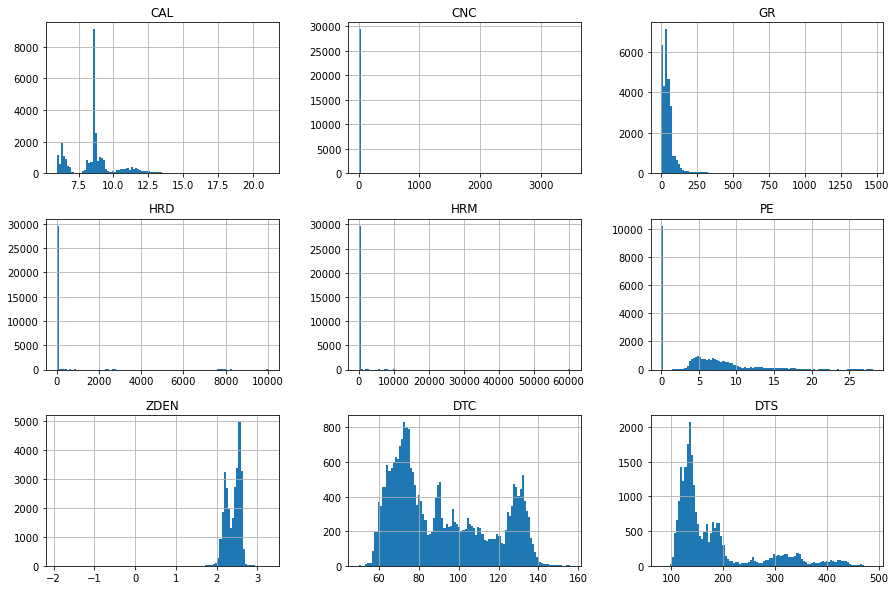

In [8]:
histdf = df.hist(bins=100,figsize=(15,10))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

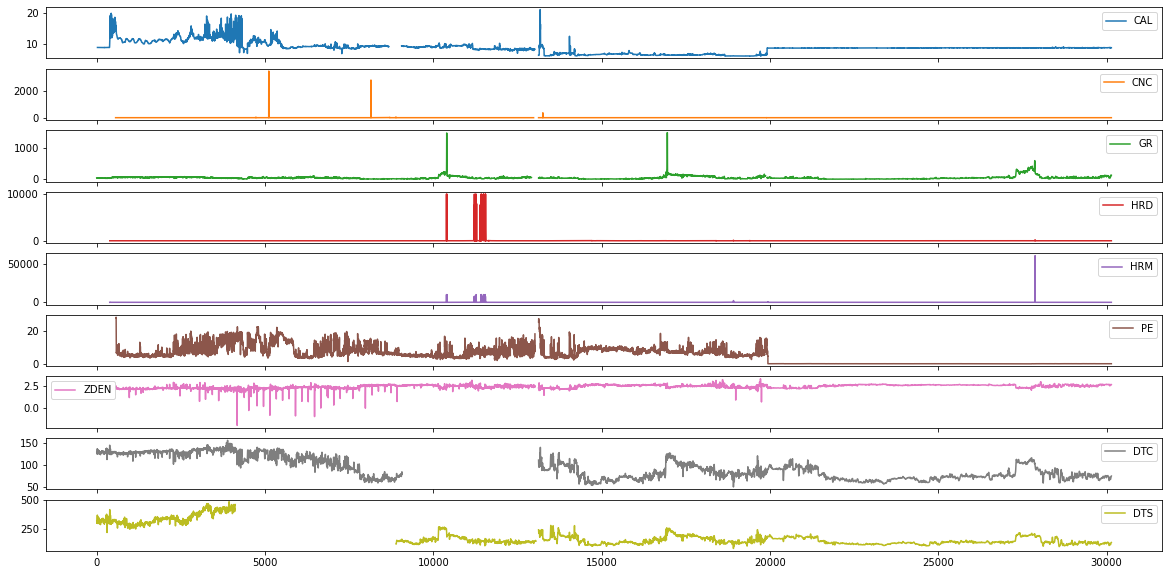

In [9]:
df.plot(subplots=True,figsize=(20,10))

Making all the negative values as null values

In [10]:
df['ZDEN'][df['ZDEN']<0] = np.nan
df['GR'][df['GR']<0] = np.nan
df['CNC'][df['CNC']<0] = np.nan
df['PE'][df['PE']<0] = np.nan

Making all the outliers as null values

In [11]:
# GR
df['GR'][(df['GR']>250)] = np.nan
# CNC
df['CNC'][df['CNC']>0.7] = np.nan
# HRM & HRD
df['HRD'][df['HRD']>200] = np.nan
df['HRM'][df['HRM']>200] = np.nan

Plotting a box plot for visualising the data

C:\Users\khank\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\khank\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\khank\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\khank\anaconda3\lib\si

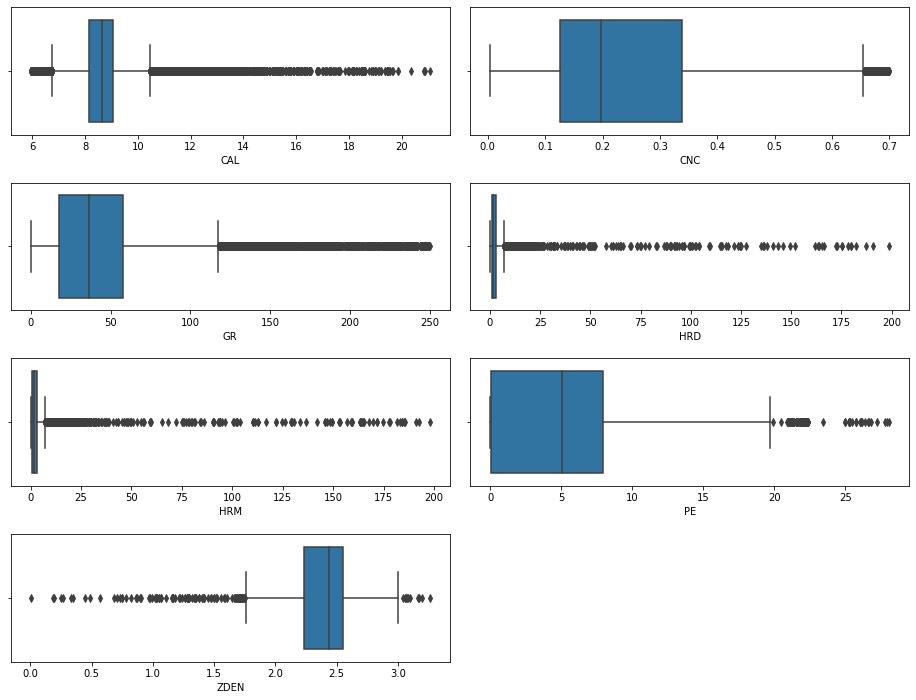

In [12]:
plt.figure(figsize=(13,10))
plt.subplot(4,2,1)
sns.boxplot(df['CAL'])

plt.subplot(4,2,2)
sns.boxplot(df['CNC'])

plt.subplot(4,2,3)
sns.boxplot(df['GR'])

plt.subplot(4,2,4)
sns.boxplot(df['HRD'])

plt.subplot(4,2,5)
sns.boxplot(df['HRM'])

plt.subplot(4,2,6)
sns.boxplot(df['PE'])

plt.subplot(4,2,7)
sns.boxplot(df['ZDEN'])

plt.tight_layout(1.7)
plt.show()

Transforming the data

In [13]:
df['HRM'] = df['HRM'].apply(lambda x:np.log(x))
df['HRD'] = df['HRD'].apply(lambda x:np.log(x))

Plotting box plot after transformation

C:\Users\khank\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\khank\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\khank\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\khank\anaconda3\lib\si

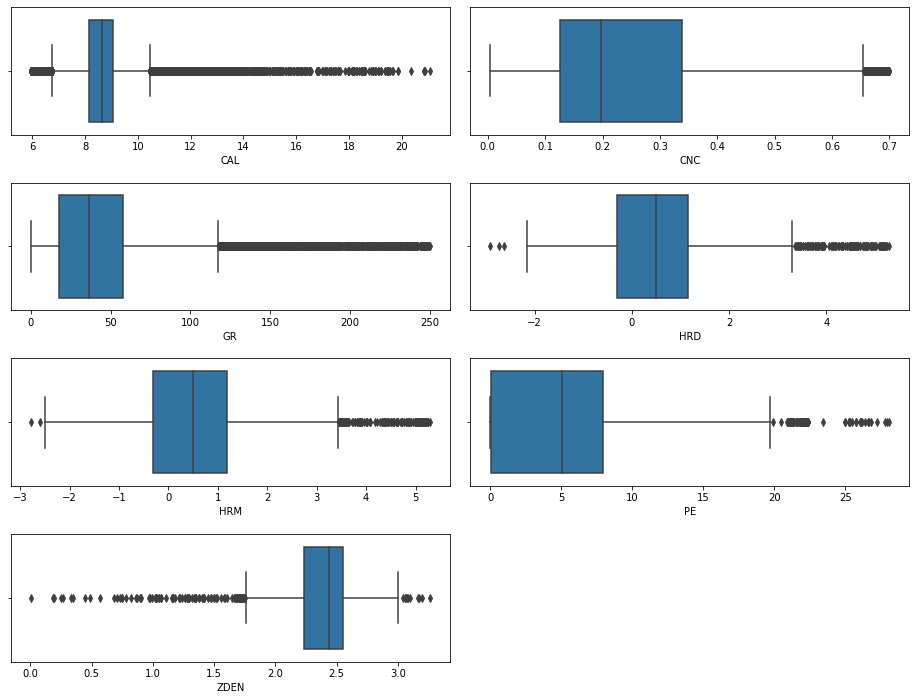

In [14]:
plt.figure(figsize=(13,10))
plt.subplot(4,2,1)
sns.boxplot(df['CAL'])

plt.subplot(4,2,2)
sns.boxplot(df['CNC'])

plt.subplot(4,2,3)
sns.boxplot(df['GR'])

plt.subplot(4,2,4)
sns.boxplot(df['HRD'])

plt.subplot(4,2,5)
sns.boxplot(df['HRM'])

plt.subplot(4,2,6)
sns.boxplot(df['PE'])

plt.subplot(4,2,7)
sns.boxplot(df['ZDEN'])

plt.tight_layout(1.7)
plt.show()

#### Finding Correlations

In [15]:
df.corr()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
CAL,1.000000,0.582005,0.040421,-0.199495,-0.164176,0.163877,-0.368183,0.585637,0.681271
CNC,0.582005,1.000000,0.486927,-0.526469,-0.531618,0.437687,-0.698973,0.943968,0.898753
GR,0.040421,0.486927,1.000000,-0.104434,-0.111190,0.031718,-0.178068,0.427692,0.308994
HRD,-0.199495,-0.526469,-0.104434,1.000000,0.981400,-0.245251,0.622416,-0.608752,-0.436526
HRM,-0.164176,-0.531618,-0.111190,0.981400,1.000000,-0.279317,0.622436,-0.605481,-0.435709
PE,0.163877,0.437687,0.031718,-0.245251,-0.279317,1.000000,-0.340607,0.477524,0.440266
ZDEN,-0.368183,-0.698973,-0.178068,0.622416,0.622436,-0.340607,1.000000,-0.756792,-0.670186
DTC,0.585637,0.943968,0.427692,-0.608752,-0.605481,0.477524,-0.756792,1.000000,0.941639
DTS,0.681271,0.898753,0.308994,-0.436526,-0.435709,0.440266,-0.670186,0.941639,1.000000


In [16]:
test_df.corr()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
CAL,1.000000,-0.290943,0.024399,0.037764,0.050929,0.446757,0.438947
CNC,-0.290943,1.000000,0.575440,-0.247362,0.016520,-0.563464,-0.710657
GR,0.024399,0.575440,1.000000,-0.124756,0.154772,-0.121305,-0.129897
HRD,0.037764,-0.247362,-0.124756,1.000000,0.415450,-0.002108,0.077118
HRM,0.050929,0.016520,0.154772,0.415450,1.000000,0.046397,0.028714
PE,0.446757,-0.563464,-0.121305,-0.002108,0.046397,1.000000,0.870180
ZDEN,0.438947,-0.710657,-0.129897,0.077118,0.028714,0.870180,1.000000


#### Predictive Power Score

The PPS is an asymmetric, data-type-agnostic score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation (matrix).

In [17]:
! pip install ppscore

<AxesSubplot:xlabel='x', ylabel='y'>

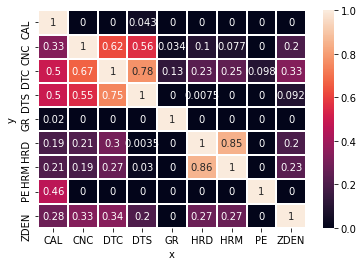

In [18]:
import ppscore as pps
matrix_df = pps.matrix(df).pivot(columns='x', index='y',  values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1,  linewidths=1.0,annot=True)

### Model Development

We have to predict two parameters DTC and DTS so we will make seperate datasets for them

In [19]:
# Create separate datasets for DTC and DTS
df_dtc = df.dropna(subset=['DTC'])
df_dts = df.dropna(subset=['DTS'])

In [20]:
df_dtc= df_dtc.dropna()
df_dts= df_dts.dropna()

#### X

In [21]:
df_dtc_x = df_dtc.drop(columns=['DTC','DTS'])
df_dts_x = df_dts.drop(columns=['DTC','DTS'])

#### Y

In [22]:
y_dtc = df_dtc['DTC']
y_dts = df_dts['DTS']

In [23]:
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(df_dtc_x,y_dtc, test_size=0.30, random_state=42, shuffle = True)

In [24]:
X_train_dts, X_test_dts, y_train_dts, y_test_dts = train_test_split(df_dts_x,y_dts, test_size=0.30, random_state=42, shuffle = True)

### We will use XB Boost model with tuned Hyperparameters for prediction

#### For DTC

In [25]:
xgb_model_dtc = xgb.XGBRegressor(random_state=42, max_depth=2,learning_rate=0.18, n_estimators=145, min_child_weight = 6, gamma = 0.3)

In [26]:
xgb_model_dtc.fit(X_train_dtc, y_train_dtc)
y_pred_test_dtc = xgb_model_dtc.predict(X_test_dtc)
y_pred_train_dtc = xgb_model_dtc.predict(X_train_dtc)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dtc,y_pred_train_dtc))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dtc,y_pred_test_dtc))))
print("R2_train:     " + str(r2_score(y_train_dtc,y_pred_train_dtc)))
print("R2_test:     " + str(r2_score(y_test_dtc,y_pred_test_dtc)))

RMSE_train:     3.5433233927184347
RMSE_test:     3.658981487924344
R2_train:     0.9771885413808177
R2_test:     0.9754925851757859


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

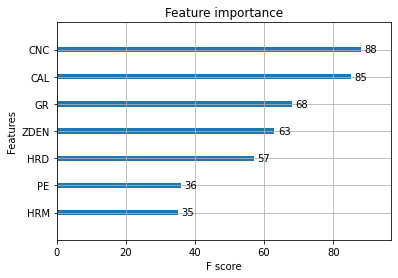

In [27]:
xgb.plot_importance(xgb_model_dtc)

#### For DTS

In [28]:
xgb_model_dts = xgb.XGBRegressor(random_state=42, max_depth=7,learning_rate=0.19, n_estimators=135, min_child_weight = 6, gamma = 0.7)

In [29]:
xgb_model_dts.fit(X_train_dts, y_train_dts)
y_pred_test_dts = xgb_model_dts.predict(X_test_dts)
y_pred_train_dts = xgb_model_dts.predict(X_train_dts)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dts,y_pred_train_dts))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dts,y_pred_test_dts))))
print("R2_train:     " + str(r2_score(y_train_dts,y_pred_train_dts)))
print("R2_test:     " + str(r2_score(y_test_dts,y_pred_test_dts)))

RMSE_train:     4.740950686168958
RMSE_test:     9.05040946344676
R2_train:     0.9968435395609115
R2_test:     0.9886220848848264


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

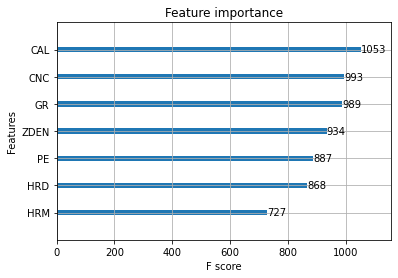

In [30]:
xgb.plot_importance(xgb_model_dts)

### Predictions for test data

Prepraring the test data

In [31]:
# Replace value -999 ( missing value indicators ) as NA
test_df.replace(['-999', -999], np.nan, inplace=True)
# Nullify the Negative Values
test_df['CNC'][test_df['CNC']<0] = np.nan
test_df['GR'][test_df['GR']<0] = np.nan
test_df['PE'][test_df['PE']<0] = np.nan
test_df['ZDEN'][test_df['ZDEN']<0] = np.nan
# Nullify the Outliers
test_df['CNC'][test_df['CNC']>0.7] = np.nan
test_df['GR'][(test_df['GR']>250)] = np.nan
test_df['HRD'][test_df['HRD']>200] = np.nan
test_df['HRM'][test_df['HRM']>200] = np.nan
# Log Transformation
test_df['HRD'] = np.log(test_df['HRD'])
test_df['HRM'] = np.log(test_df['HRM'])

In [32]:
test_df.isnull().sum()

CAL      0
CNC      0
GR      33
HRD      1
HRM     27
PE       0
ZDEN     0
dtype: int64

In [33]:
test_df['GR']= test_df['GR'].fillna(test_df['GR'].mean())
test_df['HRD']= test_df['HRD'].fillna(test_df['HRD'].mean())
test_df['HRM']= test_df['HRM'].fillna(test_df['HRM'].mean())

In [34]:
test_df.isnull().sum()

CAL     0
CNC     0
GR      0
HRD     0
HRM     0
PE      0
ZDEN    0
dtype: int64

In [35]:
test_df.shape

(11088, 7)

In [36]:
test_x= test_df.copy()

Predicting the results

In [37]:
test_df['DTC'] = xgb_model_dtc.predict(test_x)
test_df['DTS'] = xgb_model_dts.predict(test_x)

In [38]:
test_df

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.522163,212.883377
1,8.5781,0.3639,57.0114,-0.218405,-0.258382,6.8100,2.3255,107.522163,216.068619
2,8.5781,0.3703,58.9263,-0.295177,-0.349841,6.7766,2.3212,107.740486,219.608109
3,8.5625,0.3667,57.3308,-0.332819,-0.424342,6.7219,2.3119,108.656784,220.271805
4,8.5781,0.3500,53.0624,-0.379067,-0.492822,6.6384,2.2982,108.668037,216.970139
...,...,...,...,...,...,...,...,...,...
11083,8.7813,0.1882,68.0333,0.027615,-0.018673,6.5003,2.4423,79.778572,163.339661
11084,8.7344,0.1879,68.0753,0.024595,-0.017960,6.4415,2.4377,79.241875,152.435654
11085,8.7266,0.1824,68.8516,0.044878,0.019705,6.3413,2.4342,79.241875,151.334595
11086,8.7500,0.1822,70.8515,0.059118,0.052687,6.2254,2.4320,79.778572,157.820221


#### Importing the orignal prediction file

In [39]:
actual_df= pd.read_csv('real_test_result.csv')
actual_df.shape

(11088, 2)

In [40]:
pred_df= test_df[['DTC','DTS']]

In [41]:
pred_df.shape

(11088, 2)

In [42]:
preds= np.array(pred_df)
reals= np.real(actual_df)

In [43]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Combined r2 score is:', '{:.5f}'.format((r2_score(y_real, y_predict))))
    dtc_real = y_real[:, 0]
    dtc_pred = y_predict[:, 0]
    dts_real = y_real[:, 1]
    dts_pred = y_predict[:, 1]
    print('DTC:', '{:.5f}'.format((r2_score(dtc_real, dtc_pred))))
    print('DTS:', '{:.5f}'.format((r2_score(dts_real, dts_pred))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

Combined r2 score is: 0.80910
DTC: 0.90797
DTS: 0.71022


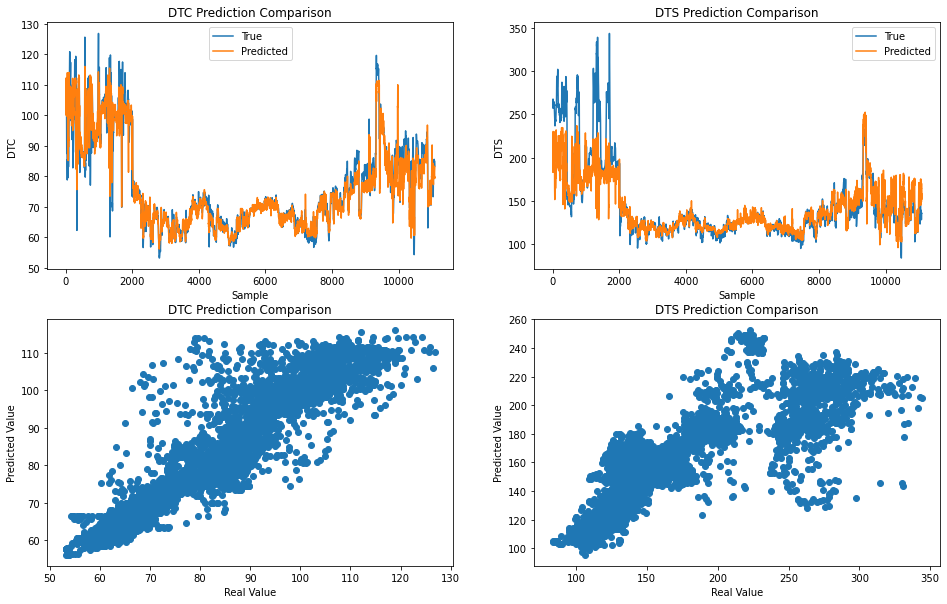

In [44]:
result_plot(preds,reals)

RMSE of test data (#1 DTC): 4.39
RMSE of test data (#2 DTS): 23.89
Overall RMSE = 17.18


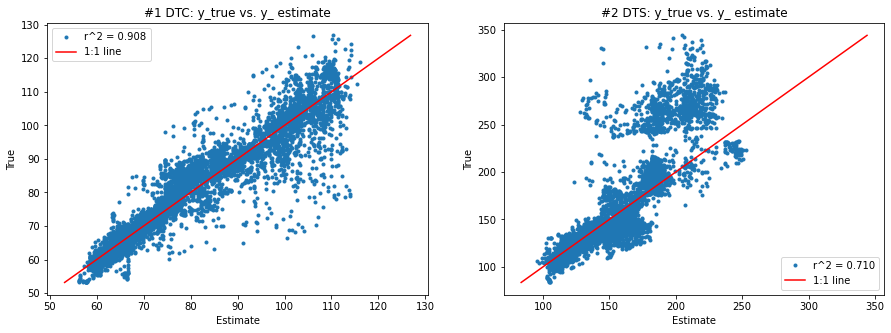

In [45]:
# Plot results:
plt.figure(figsize=(15,5))
i = 0
plt.subplot(1,2,i+1)
plt.plot(preds[:,i], reals[:,i], '.', label = 'r^2 = %.3f' % ((r2_score(reals[:,i], preds[:,i]))))
plt.plot([reals[:,i].min(),reals[:,i].max()],[reals[:,i].min(),reals[:,i].max()], 'r', label = '1:1 line')
plt.title('#1 DTC: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()
i += 1
plt.subplot(1,2,i+1)
plt.plot(preds[:,i], reals[:,i], '.', label = 'r^2 = %.3f' % ((r2_score(reals[:,i], preds[:,i]))))
plt.plot([reals[:,i].min(),reals[:,i].max()],[reals[:,i].min(),reals[:,i].max()], 'r', label = '1:1 line')
plt.title('#2 DTS: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()

MSE_0 = mean_squared_error(reals[:,0], preds[:,0]);
RMSE_0 = np.sqrt(mean_squared_error(reals[:,0], preds[:,0]));
MSE_1 = mean_squared_error(reals[:,1], preds[:,1]);
RMSE_1 = np.sqrt(mean_squared_error(reals[:,1], preds[:,1]));
print('RMSE of test data (#1 DTC): %.2f' %(RMSE_0))
print('RMSE of test data (#2 DTS): %.2f' %(RMSE_1))
print('Overall RMSE = %.2f' %np.sqrt((MSE_0+MSE_1)/2))

### Using PyCaret

#### For DTS


In [46]:
#from pycaret.regression import *

In [47]:
#df_dtspycaret= df_dts.drop(['DTC'],axis=1)

In [48]:
#model= setup(data= df_dtspycaret, target= 'DTS',normalize= True,remove_outliers=True,trigonometry_features=True,profile=True)

In [49]:
#xgb= create_model('xgboost')

In [50]:
#plot_model(xgb)

#### For DTC

In [51]:
#df_dtcpycaret= df_dtc.drop(['DTS'],axis=1)

In [52]:
#model= setup(data= df_dtspycaret, target= 'DTS',normalize= True,remove_outliers=True,trigonometry_features=True,profile=True)

In [53]:
#xgb= create_model('xgboost')

In [54]:
#plot_model(xgb)

As we have done the prediction for our data without the transformation now we will proceed with the wavelet transformation

### 2) Wavelet Transformation

For this we have to select a feature for which we will do the transformation

For this we will use SHAP value graph

In [55]:
import shap
# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(xgb_model_dts)

In [56]:
shap_values = explainer.shap_values(test_x)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


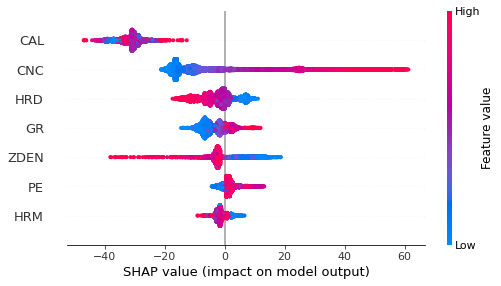

In [57]:
# summarize the effects of all the features
shap.summary_plot(shap_values, test_x)

From this graph and feature importance graph we will select Neutron log (CNC) for wavelet transformation

Defining functions for wavelet transformation

In [58]:
#This function is defined for descrete wavelet transform and calculating the cA ie the approximate coefficient
def make_dwt_vars_cA(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    
    grouped = wells_df
    new_df = pd.DataFrame()
    for key in grouped.keys():
    
        depth = grouped['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped[log]
              
            for i in levels:
                
                    cA_cD = pywt.wavedec(temp_data,wave,level=i,mode='symmetric')
                    cA = cA_cD[0]
                    new_depth = np.linspace(min(depth),max(depth),len(cA))
                    fA = interp1d(new_depth,cA,kind='nearest')
                    temp_df[log + '_cA_level_' + str(i)] = fA(depth)
    
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Depth'],axis=1)
    return new_df

In [59]:
#This is a user defined function for discrte wavelet transform cD, cD is also called the detailed  coefficient
def make_dwt_vars_cD(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    
    grouped = wells_df
    new_df = pd.DataFrame()
    for key in grouped.keys():
    
        depth = grouped['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped[log]

            cA_4, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(temp_data,wave,level=4,mode='symmetric')
            dict_cD_levels = {1:cD_1, 2:cD_2, 3:cD_3, 4:cD_4}
                
            for i in levels:
                new_depth = np.linspace(min(depth),max(depth),len(dict_cD_levels[i]))
                fA = interp1d(new_depth,dict_cD_levels[i],kind='nearest')
                temp_df[log + '_cD_level_' + str(i)] = fA(depth)
    
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Depth'],axis=1)
    return new_df

In our data we don't have depth columns so we have to make depth column first

### First we will do everything for our train data

We will do the transformation on our train data whole

In [60]:
df_wavelet= df.copy()

In [61]:
df_wavelet= df_wavelet.dropna()

In [62]:
df_wavelet.shape

(20036, 9)

In [63]:
depth_train= np.linspace(500,4000,len(df_wavelet))

In [64]:
df_wavelet['Depth']= depth_train

### haar wavelet transformation

In [65]:
import pywt
from scipy.interpolate import interp1d

In [66]:
#cD From wavelet db4
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=df_wavelet, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='haar')

# cA From wavelet db4
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=df_wavelet, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='haar')

In [67]:
list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = df_wavelet
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
training_data=combined_df

(200360, 18)


Let us view our data for a section

In [68]:
df_zone1= training_data[training_data['Depth']<1000]

Text(0.5, 0.94, 'CMC log and corresponding cD cofficients found via haar for Well: ')

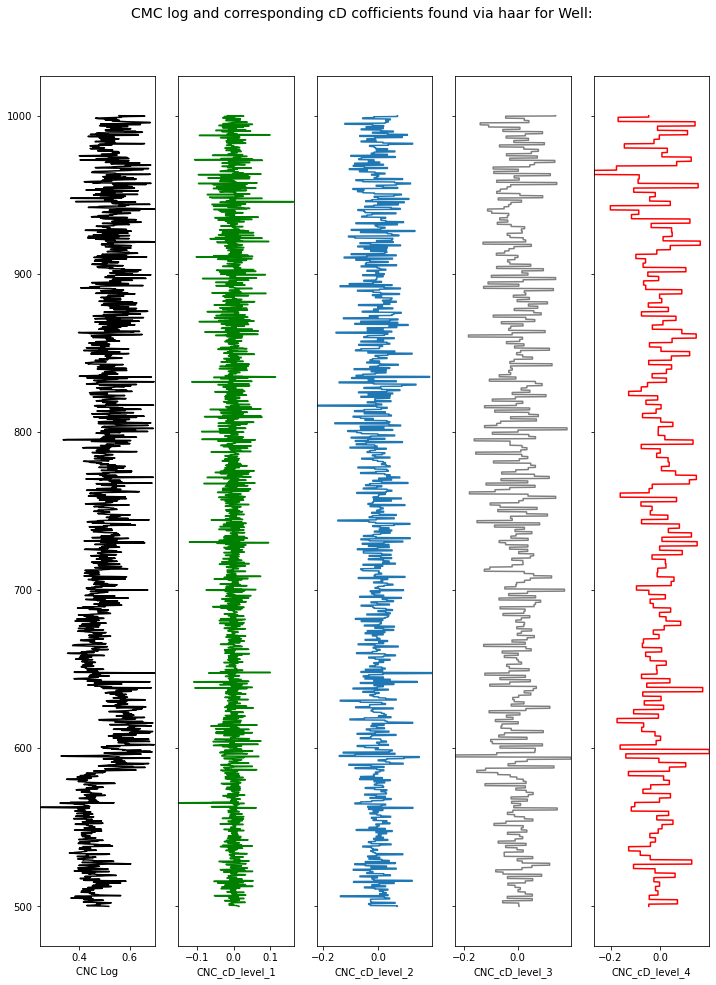

In [69]:
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 16))
ax[0].plot(df_zone1.CNC, df_zone1.Depth, '-', color='black')
ax[1].plot(df_zone1.CNC_cD_level_1, df_zone1.Depth, '-g')
ax[2].plot(df_zone1.CNC_cD_level_2, df_zone1.Depth, '-')
ax[3].plot(df_zone1.CNC_cD_level_3, df_zone1.Depth, '-', color='0.5')
ax[4].plot(df_zone1.CNC_cD_level_4, df_zone1.Depth, '-', color='r')

ax[0].set_xlabel("CNC Log")
ax[0].set_xlim(df_zone1.CNC.min(),df_zone1.CNC.max())
ax[1].set_xlabel("CNC_cD_level_1")
ax[1].set_xlim(df_zone1.CNC_cD_level_1.min(),df_zone1.CNC_cD_level_1.max())
ax[2].set_xlabel("CNC_cD_level_2")
ax[2].set_xlim(df_zone1.CNC_cD_level_2.min(),df_zone1.CNC_cD_level_2.max())
ax[3].set_xlabel("CNC_cD_level_3")
ax[3].set_xlim(df_zone1.CNC_cD_level_3.min(),df_zone1.CNC_cD_level_3.max())
ax[4].set_xlabel("CNC_cD_level_4")
ax[4].set_xlim(df_zone1.CNC_cD_level_4.min(),df_zone1.CNC_cD_level_4.max())

ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
ax[4].set_yticklabels([]); 

f.suptitle('CMC log and corresponding cD cofficients found via haar for Well: ', fontsize=14,y=0.94)

Now again we will do the same procedure for predictions

In [70]:
# Create separate datasets for DTC and DTS
df_dtc_wave = training_data.dropna(subset=['DTC'])
df_dts_wave = training_data.dropna(subset=['DTS'])

In [71]:
df_dtc_x_wave = df_dtc_wave.drop(columns=['DTC','DTS'])
df_dts_x_wave = df_dts_wave.drop(columns=['DTC','DTS'])

In [72]:
y_dtc_wave = df_dtc_wave['DTC']
y_dts_wave = df_dts_wave['DTS']

In [73]:
X_train_dtc_wave, X_test_dtc_wave, y_train_dtc_wave, y_test_dtc_wave = train_test_split(df_dtc_x_wave,y_dtc_wave, test_size=0.30, random_state=42, shuffle = True)

In [74]:
X_train_dts_wave, X_test_dts_wave, y_train_dts_wave, y_test_dts_wave = train_test_split(df_dts_x_wave,y_dts_wave, test_size=0.30, random_state=42, shuffle = True)

#### For DTC

In [75]:
xgb_model_dtc_wave = xgb.XGBRegressor(random_state=42, max_depth=2,learning_rate=0.18, n_estimators=145, min_child_weight = 6, gamma = 0.3)

In [76]:
xgb_model_dtc_wave.fit(X_train_dtc_wave, y_train_dtc_wave)
y_pred_test_dtc_wave = xgb_model_dtc_wave.predict(X_test_dtc_wave)
y_pred_train_dtc_wave = xgb_model_dtc_wave.predict(X_train_dtc_wave)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dtc_wave,y_pred_train_dtc_wave))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dtc_wave,y_pred_test_dtc_wave))))
print("R2_train:     " + str(r2_score(y_train_dtc_wave,y_pred_train_dtc_wave)))
print("R2_test:     " + str(r2_score(y_test_dtc_wave,y_pred_test_dtc_wave)))

RMSE_train:     2.925752620348936
RMSE_test:     2.9322708861079683
R2_train:     0.9844242911874924
R2_test:     0.9843154250033611


#### For DTS

In [77]:
xgb_model_dts_wave = xgb.XGBRegressor(random_state=42, max_depth=7,learning_rate=0.19, n_estimators=135, min_child_weight = 6, gamma = 0.7)

In [78]:
xgb_model_dts_wave.fit(X_train_dts_wave, y_train_dts_wave)
y_pred_test_dts_wave = xgb_model_dts_wave.predict(X_test_dts_wave)
y_pred_train_dts_wave = xgb_model_dts_wave.predict(X_train_dts_wave)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dts_wave,y_pred_train_dts_wave))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dts_wave,y_pred_test_dts_wave))))
print("R2_train:     " + str(r2_score(y_train_dts_wave,y_pred_train_dts_wave)))
print("R2_test:     " + str(r2_score(y_test_dts_wave,y_pred_test_dts_wave)))

RMSE_train:     2.064222323771584
RMSE_test:     2.1531322674798643
R2_train:     0.9994023793154604
R2_test:     0.999354118164179


### Predictions for test data

In [79]:
merge= [test_x,actual_df]

In [80]:
wavelet_test_df= pd.concat(merge,axis=1)

In [81]:
wavelet_test_df.shape

(11088, 9)

In [82]:
wavelet_test_df

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.0669,261.0363
1,8.5781,0.3639,57.0114,-0.218405,-0.258382,6.8100,2.3255,107.8095,260.1601
2,8.5781,0.3703,58.9263,-0.295177,-0.349841,6.7766,2.3212,108.2305,261.0667
3,8.5625,0.3667,57.3308,-0.332819,-0.424342,6.7219,2.3119,108.4281,262.5100
4,8.5781,0.3500,53.0624,-0.379067,-0.492822,6.6384,2.2982,108.2227,263.3599
...,...,...,...,...,...,...,...,...,...
11083,8.7813,0.1882,68.0333,0.027615,-0.018673,6.5003,2.4423,83.1931,133.2146
11084,8.7344,0.1879,68.0753,0.024595,-0.017960,6.4415,2.4377,83.3988,134.3225
11085,8.7266,0.1824,68.8516,0.044878,0.019705,6.3413,2.4342,83.7630,135.2511
11086,8.7500,0.1822,70.8515,0.059118,0.052687,6.2254,2.4320,84.5598,135.9369


Now we will perform wavelet transformation on this data

In [83]:
depth_test= np.linspace(500,4000,len(wavelet_test_df))

In [84]:
wavelet_test_df['Depth']= depth_test

In [85]:
wavelet_test_df.isnull().sum()

CAL        0
CNC        0
GR         0
HRD        0
HRM        0
PE         0
ZDEN       0
DTC        0
DTS        0
Depth      0
dtype: int64

In [86]:
#cD From wavelet db4
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=wavelet_test_df, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='haar')

# cA From wavelet db4
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=wavelet_test_df, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='haar')

In [87]:

list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = wavelet_test_df
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
testing_data=combined_df

(110880, 18)


In [88]:
testing_data.columns

Index(['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC    ', 'DTS  ',
       'Depth', 'CNC_cD_level_1', 'CNC_cD_level_2', 'CNC_cD_level_3',
       'CNC_cD_level_4', 'CNC_cA_level_1', 'CNC_cA_level_2', 'CNC_cA_level_3',
       'CNC_cA_level_4'],
      dtype='object')

In [89]:
final_test_df= testing_data.drop(['DTC    ','DTS  '],axis=1)

In [90]:
final_test_df_dtc= final_test_df.copy()
final_test_df_dts= final_test_df.copy()

#### Predictions

In [91]:
X_train_dtc_wave.columns

Index(['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'Depth',
       'CNC_cD_level_1', 'CNC_cD_level_2', 'CNC_cD_level_3', 'CNC_cD_level_4',
       'CNC_cA_level_1', 'CNC_cA_level_2', 'CNC_cA_level_3', 'CNC_cA_level_4'],
      dtype='object')

In [92]:
final_test_df_dtc.columns

Index(['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'Depth',
       'CNC_cD_level_1', 'CNC_cD_level_2', 'CNC_cD_level_3', 'CNC_cD_level_4',
       'CNC_cA_level_1', 'CNC_cA_level_2', 'CNC_cA_level_3', 'CNC_cA_level_4'],
      dtype='object')

In [93]:
final_test_df_dts.columns

Index(['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'Depth',
       'CNC_cD_level_1', 'CNC_cD_level_2', 'CNC_cD_level_3', 'CNC_cD_level_4',
       'CNC_cA_level_1', 'CNC_cA_level_2', 'CNC_cA_level_3', 'CNC_cA_level_4'],
      dtype='object')

In [94]:
final_test_df['DTC']= xgb_model_dtc_wave.predict(final_test_df_dtc)
final_test_df['DTS']= xgb_model_dts_wave.predict(final_test_df_dts)

In [95]:
final_test_df

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,Depth,CNC_cD_level_1,CNC_cD_level_2,CNC_cD_level_3,CNC_cD_level_4,CNC_cA_level_1,CNC_cA_level_2,CNC_cA_level_3,CNC_cA_level_4,DTC,DTS
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,500.0,-0.008344,-0.01050,0.060245,-0.024025,0.506288,0.72650,0.967181,1.391825,115.608177,307.218903
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,500.0,-0.008344,-0.01050,0.060245,-0.024025,0.506288,0.72650,0.967181,1.391825,115.608177,307.218903
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,500.0,-0.008344,-0.01050,0.060245,-0.024025,0.506288,0.72650,0.967181,1.391825,115.608177,307.218903
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,500.0,-0.008344,-0.01050,0.060245,-0.024025,0.506288,0.72650,0.967181,1.391825,115.608177,307.218903
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,500.0,-0.008344,-0.01050,0.060245,-0.024025,0.506288,0.72650,0.967181,1.391825,115.608177,307.218903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,4000.0,-0.001273,0.00205,0.018137,0.029450,0.258943,0.36825,0.538921,0.791600,75.058876,129.173889
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,4000.0,-0.001273,0.00205,0.018137,0.029450,0.258943,0.36825,0.538921,0.791600,75.058876,129.173889
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,4000.0,-0.001273,0.00205,0.018137,0.029450,0.258943,0.36825,0.538921,0.791600,75.058876,129.173889
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,4000.0,-0.001273,0.00205,0.018137,0.029450,0.258943,0.36825,0.538921,0.791600,75.058876,129.173889


In [96]:
testing_data

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,Depth,CNC_cD_level_1,CNC_cD_level_2,CNC_cD_level_3,CNC_cD_level_4,CNC_cA_level_1,CNC_cA_level_2,CNC_cA_level_3,CNC_cA_level_4
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.0669,261.0363,500.0,-0.008344,-0.01050,0.060245,-0.024025,0.506288,0.72650,0.967181,1.391825
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.0669,261.0363,500.0,-0.008344,-0.01050,0.060245,-0.024025,0.506288,0.72650,0.967181,1.391825
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.0669,261.0363,500.0,-0.008344,-0.01050,0.060245,-0.024025,0.506288,0.72650,0.967181,1.391825
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.0669,261.0363,500.0,-0.008344,-0.01050,0.060245,-0.024025,0.506288,0.72650,0.967181,1.391825
0,8.5781,0.3521,55.1824,-0.208132,-0.247180,6.8291,2.3256,107.0669,261.0363,500.0,-0.008344,-0.01050,0.060245,-0.024025,0.506288,0.72650,0.967181,1.391825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,84.8668,135.7406,4000.0,-0.001273,0.00205,0.018137,0.029450,0.258943,0.36825,0.538921,0.791600
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,84.8668,135.7406,4000.0,-0.001273,0.00205,0.018137,0.029450,0.258943,0.36825,0.538921,0.791600
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,84.8668,135.7406,4000.0,-0.001273,0.00205,0.018137,0.029450,0.258943,0.36825,0.538921,0.791600
11087,8.7500,0.1840,69.9109,0.058458,0.044304,6.1295,2.4313,84.8668,135.7406,4000.0,-0.001273,0.00205,0.018137,0.029450,0.258943,0.36825,0.538921,0.791600


In [97]:
testing_data.columns

Index(['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC    ', 'DTS  ',
       'Depth', 'CNC_cD_level_1', 'CNC_cD_level_2', 'CNC_cD_level_3',
       'CNC_cD_level_4', 'CNC_cA_level_1', 'CNC_cA_level_2', 'CNC_cA_level_3',
       'CNC_cA_level_4'],
      dtype='object')

In [98]:
pred_wave_df= final_test_df[['DTC','DTS']]
real_wave_df= testing_data[['DTC    ','DTS  ']]

In [99]:
preds_wave= np.array(pred_wave_df)
reals_wave= np.array(real_wave_df)

In [100]:
merge1= [testing_data['DTS  '],final_test_df['DTS']]
dts= pd.concat(merge1,axis=1)

In [101]:
dts['res']= dts['DTS  ']-dts['DTS']

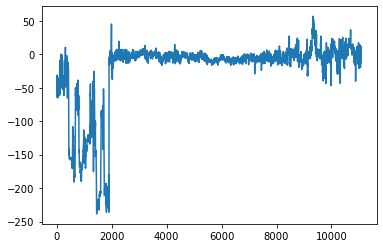

In [102]:
plt.plot(dts['res'])

### Trying wavelet on Caliper log for dts prediction

In [103]:
df_wavelet_cal= df.copy()
df_wavelet_cal= df_wavelet_cal.dropna()
depth_train_cal= np.linspace(500,4000,len(df_wavelet_cal))
df_wavelet_cal['Depth']= depth_train_cal
#cD From wavelet db4
dwt_db4_cD_df_cal = make_dwt_vars_cD(wells_df=df_wavelet_cal, logs=['CAL'],levels=[1, 2, 3, 4], wavelet='haar')

# cA From wavelet db4
dwt_db4_cA_df_cal = make_dwt_vars_cA(wells_df=df_wavelet_cal, logs=['CAL'],levels=[1, 2, 3, 4], wavelet='haar')
list_df_var_cal = [dwt_db4_cD_df_cal, dwt_db4_cA_df_cal]
combined_df_cal = df_wavelet_cal
for var_df_cal in list_df_var_cal:
    temp_df_cal = var_df_cal
    combined_df_cal = pd.concat([combined_df_cal,temp_df_cal],axis=1)
combined_df_cal.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df_cal.shape)
training_data_cal=combined_df_cal

df_dts_x_wave_cal = training_data_cal.drop(columns=['DTC','DTS'])
y_dts_wave_cal = training_data_cal['DTS']

X_train_dts_wave_cal, X_test_dts_wave_cal, y_train_dts_wave_cal, y_test_dts_wave_cal = train_test_split(df_dts_x_wave_cal,y_dts_wave_cal, test_size=0.30, random_state=42, shuffle = True)

xgb_model_dts_wave_cal = xgb.XGBRegressor(random_state=42, max_depth=7,learning_rate=0.19, n_estimators=135, min_child_weight = 6, gamma = 0.7)
xgb_model_dts_wave_cal.fit(X_train_dts_wave_cal, y_train_dts_wave_cal)
y_pred_test_dts_wave_cal = xgb_model_dts_wave_cal.predict(X_test_dts_wave_cal)
y_pred_train_dts_wave_cal = xgb_model_dts_wave_cal.predict(X_train_dts_wave_cal)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dts_wave_cal,y_pred_train_dts_wave_cal))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dts_wave_cal,y_pred_test_dts_wave_cal))))
print("R2_train:     " + str(r2_score(y_train_dts_wave_cal,y_pred_train_dts_wave_cal)))
print("R2_test:     " + str(r2_score(y_test_dts_wave_cal,y_pred_test_dts_wave_cal)))




(200360, 18)
RMSE_train:     2.2734308285412737
RMSE_test:     2.3568786205647476
R2_train:     0.999275103221888
R2_test:     0.9992260977917286


In [104]:
wavelet_test_df= wavelet_test_df[2000:]
wavelet_test_df

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,Depth
2000,8.6719,0.2440,47.3355,0.034208,-0.032627,6.1380,2.3395,92.9369,164.8163,1131.370073
2001,8.6719,0.2639,55.9759,0.065226,0.032370,6.4860,2.3451,96.7441,172.4452,1131.685758
2002,8.6719,0.2798,63.2165,0.059400,-0.014302,6.8482,2.3543,98.3755,179.9856,1132.001443
2003,8.7031,0.2930,67.5962,0.030723,-0.087521,7.1327,2.3661,98.7588,186.2317,1132.317128
2004,8.7031,0.3080,68.9573,0.026837,-0.108476,7.3104,2.3799,98.0004,191.3415,1132.632813
...,...,...,...,...,...,...,...,...,...,...
11083,8.7813,0.1882,68.0333,0.027615,-0.018673,6.5003,2.4423,83.1931,133.2146,3998.737260
11084,8.7344,0.1879,68.0753,0.024595,-0.017960,6.4415,2.4377,83.3988,134.3225,3999.052945
11085,8.7266,0.1824,68.8516,0.044878,0.019705,6.3413,2.4342,83.7630,135.2511,3999.368630
11086,8.7500,0.1822,70.8515,0.059118,0.052687,6.2254,2.4320,84.5598,135.9369,3999.684315


In [105]:
#cD From wavelet db4
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=wavelet_test_df, logs=['CAL'],levels=[1, 2, 3, 4], wavelet='haar')

# cA From wavelet db4
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=wavelet_test_df, logs=['CAL'],levels=[1, 2, 3, 4], wavelet='haar')


list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = wavelet_test_df
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
testing_data=combined_df



(90880, 18)


In [106]:
testing_data_cal=combined_df

final_test_df_cal= testing_data_cal.drop(['DTC    ','DTS  '],axis=1)
final_test_df_dts_cal= final_test_df_cal.copy()

final_test_df_dts_cal['DTS']= xgb_model_dts_wave_cal.predict(final_test_df_dts_cal)

#print(r2_score(testing_data_cal['DTS  '],final_test_df_cal['DTS']))

In [107]:
final_test_df_dts_cal['DTS']

2000     194.427856
2000     194.427856
2000     194.427856
2000     194.427856
2000     194.427856
            ...    
11087    157.850052
11087    157.850052
11087    157.850052
11087    157.850052
11087    157.850052
Name: DTS, Length: 90880, dtype: float32

In [108]:
testing_data_cal['DTS  ']

2000     164.8163
2000     164.8163
2000     164.8163
2000     164.8163
2000     164.8163
           ...   
11087    135.7406
11087    135.7406
11087    135.7406
11087    135.7406
11087    135.7406
Name: DTS  , Length: 90880, dtype: float64

In [109]:
print(np.sqrt(r2_score(testing_data_cal['DTS  '],final_test_df_dts_cal['DTS'])))

0.8071898762979353


In [110]:
merge1= [testing_data_cal['DTS  '],final_test_df_dts_cal['DTS']]
dts1= pd.concat(merge1,axis=1)

In [111]:
dts1['res']= dts1['DTS  ']-dts1['DTS']

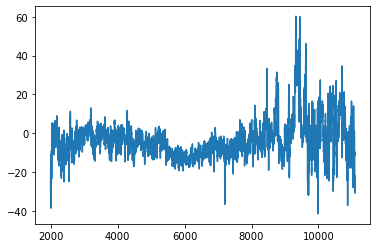

In [112]:
plt.plot(dts1['res'])

## Final result plots

DTC: 0.89518
DTS: 0.80719


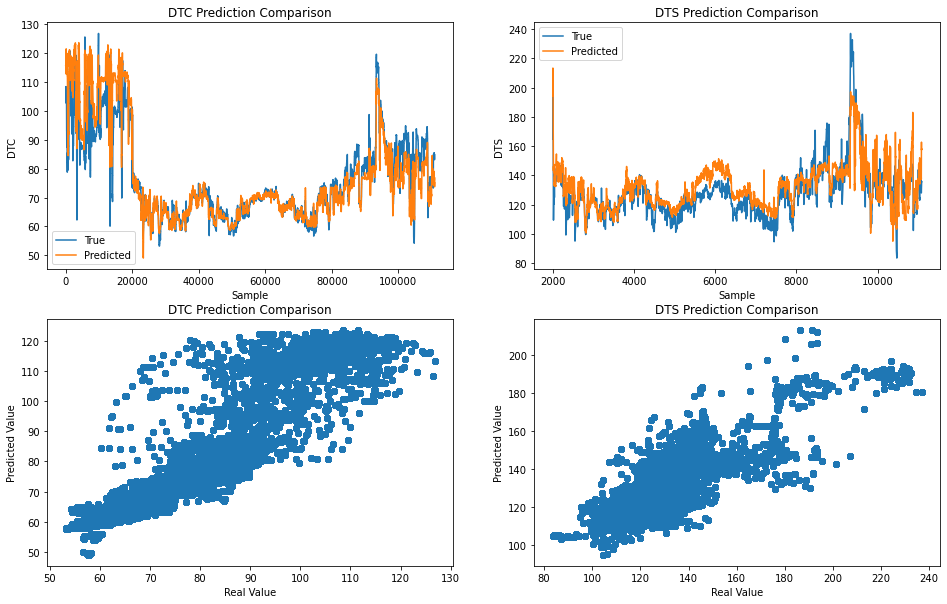

In [113]:
# check the accuracy of predicted data and plot the result
#print('Combined r2 score is:', '{:.5f}'.format((r2_score(y_real, y_predict))))
dtc_real = reals_wave[:, 0]
dtc_pred = preds_wave[:, 0]
dts_real = testing_data_cal['DTS  ']
dts_pred = final_test_df_dts_cal['DTS']
print('DTC:', '{:.5f}'.format(np.sqrt(r2_score(dtc_real, dtc_pred))))
print('DTS:', '{:.5f}'.format(np.sqrt(r2_score(dts_real, dts_pred))))
plt.subplots(nrows=2, ncols=2, figsize=(16,10))
plt.subplot(2, 2, 1)
plt.plot(reals_wave[:, 0])
plt.plot(preds_wave[:, 0])
plt.legend(['True', 'Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')
    
plt.subplot(2, 2, 2)
plt.plot(testing_data_cal['DTS  '])
plt.plot(final_test_df_dts_cal['DTS'])
plt.legend(['True', 'Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
    
plt.subplot(2, 2, 3)
plt.scatter(reals_wave[:, 0], preds_wave[:, 0])
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.title('DTC Prediction Comparison')
    
plt.subplot(2, 2, 4)
plt.scatter(testing_data_cal['DTS  '], final_test_df_dts_cal['DTS'])
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.title('DTS Prediction Comparison')

plt.show()

RMSE of test data (#1 DTC): 6.46
RMSE of test data (#2 DTS): 10.66
Overall RMSE = 8.81


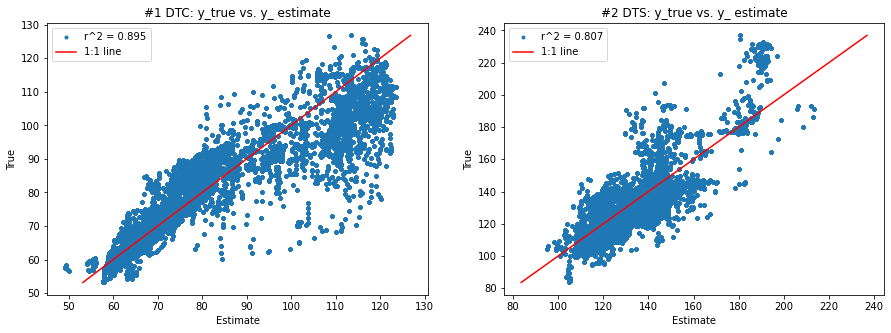

In [114]:
# Plot results:
plt.figure(figsize=(15,5))
i = 0
plt.subplot(1,2,i+1)
plt.plot(preds_wave[:,i], reals_wave[:,i], '.', label = 'r^2 = %.3f' % (np.sqrt(r2_score(reals_wave[:,i], preds_wave[:,i]))))
plt.plot([reals_wave[:,i].min(),reals_wave[:,i].max()],[reals_wave[:,i].min(),reals_wave[:,i].max()], 'r', label = '1:1 line')
plt.title('#1 DTC: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()
i += 1
plt.subplot(1,2,i+1)
plt.plot(final_test_df_dts_cal['DTS'], testing_data_cal['DTS  '], '.', label = 'r^2 = %.3f' % np.sqrt((r2_score(testing_data_cal['DTS  '], final_test_df_dts_cal['DTS']))))
plt.plot([testing_data_cal['DTS  '].min(),testing_data_cal['DTS  '].max()],[testing_data_cal['DTS  '].min(),testing_data_cal['DTS  '].max()], 'r', label = '1:1 line')
plt.title('#2 DTS: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()

MSE_0 = mean_squared_error(reals_wave[:,0], preds_wave[:,0]);
RMSE_0 = np.sqrt(mean_squared_error(reals_wave[:,0], preds_wave[:,0]));
MSE_1 = mean_squared_error(testing_data_cal['DTS  '], final_test_df_dts_cal['DTS']);
RMSE_1 = np.sqrt(mean_squared_error(testing_data_cal['DTS  '], final_test_df_dts_cal['DTS']));
print('RMSE of test data (#1 DTC): %.2f' %(RMSE_0))
print('RMSE of test data (#2 DTS): %.2f' %(RMSE_1))
print('Overall RMSE = %.2f' %np.sqrt((MSE_0+MSE_1)/2))

In [115]:
meandtc= np.sqrt(r2_score(dtc_real, dtc_pred))
meandts= np.sqrt(r2_score(dts_real, dts_pred))             
test_list= [meandtc,meandts]
sum = 0
for ele in test_list:
    sum += ele
res = sum / len(test_list)

In [116]:
print("Combined r2 after wavelet transformation is :",res)

Combined r2 after wavelet transformation is : 0.8511872538803915
